# Artifical Deep Neural Network

This notebook contains the steps used to create a deep neural network based on penguin dataset.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

## 1. Scale and view a sample of the penguin dataset

In [21]:
import torch
import torch.nn as nn
import torch.utils.data as td
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
import time
from IPython.display import display, clear_output

In [22]:
# load the training dataset (excluding rows with null values)
penguins = pd.read_csv('data/penguins.csv').dropna()

# Scale the FlipperLength and BodyMass so they're on a similar scale to the bill measurements
penguins['FlipperLength'] = penguins['FlipperLength']/10
penguins['BodyMass'] = penguins['BodyMass']/100

# The dataset is too small to be useful for deep learning the data is trebbled
for i in range(1,3):
    penguins = penguins.append(penguins)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
count,10.00000,10.000000,10.000000,10.000000,10.000000
mean,44.23000,16.670000,20.300000,45.275000,0.700000
std,5.68586,2.126578,1.504807,7.517064,0.674949
min,36.80000,14.300000,17.800000,35.000000,0.000000
25%,39.30000,14.625000,19.075000,39.875000,0.000000
50%,45.65000,16.700000,20.850000,46.375000,1.000000
75%,47.55000,18.400000,21.475000,48.500000,1.000000
max,52.80000,20.000000,22.200000,57.500000,2.000000


## 2. Split the dataset into a training and testing dataset

In [8]:
penguin_classes = ['Amelie', 'Gentoo', 'Chinstrap']
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'
   
# Split data 70%-30% into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[features].values,
                                                    penguins[label].values,
                                                    test_size=0.30,
                                                    random_state=0)

print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n], '(' + penguin_classes[y_train[n]] + ')')

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5 22.5 52.5] 1 (Gentoo)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.5 16.2 22.9 58. ] 1 (Gentoo)
[39.3 20.6 19.  36.5] 0 (Amelie)
[42.5 20.7 19.7 45. ] 0 (Amelie)
[50.  15.3 22.  55.5] 1 (Gentoo)
[50.2  18.7  19.8  37.75] 2 (Chinstrap)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.1  14.5  21.2  46.25] 1 (Gentoo)
[43.2 16.6 18.7 29. ] 2 (Chinstrap)
[38.8  17.6  19.1  32.75] 0 (Amelie)
[37.8 17.1 18.6 33. ] 0 (Amelie)
[45.8 14.2 21.9 47. ] 1 (Gentoo)
[43.8 13.9 20.8 43. ] 1 (Gentoo)
[36.  17.1 18.7 37. ] 0 (Amelie)
[43.3 13.4 20.9 44. ] 1 (Gentoo)
[36.  18.5 18.6 31. ] 0 (Amelie)
[41.1  19.   18.2  34.25] 0 (Amelie)
[33.1 16.1 17.8 29. ] 0 (Amelie)
[40.9 13.7 21.4 46.5] 1 (Gentoo)
[45.2 17.8 19.8 39.5] 2 (Chinstrap)
[48.4 14.6 21.3 58.5] 1 (Gentoo)
[43.6 13.9 21.7 49. ] 1 (Gentoo)
[38.5  17.9  19.   33.25] 0 (Amelie)


## 3. Prepare the data for PyTorch

In [10]:
# Set random seed for reproducability
torch.manual_seed(0)

"""PyTorch makes use of data loaders to load training and validation data in batches. We've already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (in which the data is converted to PyTorch tensor objects) and create loaders to read batches from those datasets."""

# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
    shuffle=False, num_workers=1)

print('Ready to load data..')

## 4. Define a Neural Network

In [11]:
"""Now we're ready to define our neural network. In this case, we'll create a network that consists of 3 fully-connected layers:

An input layer that receives an input value for each feature (in this case, the four penguin measurements) and applies a ReLU activation function.
A hidden layer that receives ten inputs and applies a ReLU activation function.
An output layer that uses a SoftMax activation function to generate an output for each penguin species (which represent the classification probabilities for each of the three possible penguin species)"""
# Number of hidden layer nodes
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(features), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(penguin_classes))

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=1)
        return x

# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


## 5. Train the model

In [12]:
"""To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

To do this, we'll create a function to train and optimize the model, and function to test the model. Then we'll call these functions iteratively over 50 epochs, logging the loss and accuracy statistics for each epoch."""

def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)

            # calculate the loss
            test_loss += loss_criteria(out, target).item()

            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
            
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)


Epoch: 1
Training set: Average loss: 1.091498
Validation set: Average loss: 1.025534, Accuracy: 246/411 (60%)

Epoch: 2
Training set: Average loss: 1.000949
Validation set: Average loss: 0.982450, Accuracy: 314/411 (76%)

Epoch: 3
Training set: Average loss: 0.953905
Validation set: Average loss: 0.937909, Accuracy: 321/411 (78%)

Epoch: 4
Training set: Average loss: 0.906742
Validation set: Average loss: 0.893166, Accuracy: 322/411 (78%)

Epoch: 5
Training set: Average loss: 0.860262
Validation set: Average loss: 0.853027, Accuracy: 322/411 (78%)

Epoch: 6
Training set: Average loss: 0.818910
Validation set: Average loss: 0.816758, Accuracy: 323/411 (79%)

Epoch: 7
Training set: Average loss: 0.783247
Validation set: Average loss: 0.782575, Accuracy: 334/411 (81%)

Epoch: 8
Training set: Average loss: 0.750349
Validation set: Average loss: 0.748868, Accuracy: 353/411 (86%)

Epoch: 9
Training set: Average loss: 0.719538
Validation set: Average loss: 0.718091, Accuracy: 373/411 (91%)

E

## 6. Review training and validation loss

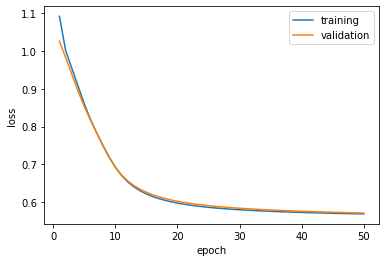

In [13]:
"""After training is complete, we can examine the loss metrics we recorded while training and validating the model. We're really looking for two things:

The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
The training loss and validations loss should follow a similar trend, showing that the model is not overfitting to the training data.
Let's plot the loss metrics and see:"""

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 7. View the learned weights and biases

In [15]:
"""The trained model consists of the final weights and biases that were determined by the optimizer during training. Based on our network model we should expect the following values for each layer:

Layer 1: There are four input values going to ten output nodes, so there should be 10 x 4 weights and 10 bias values.
Layer 2: There are ten input values going to ten output nodes, so there should be 10 x 10 weights and 10 bias values.
Layer 3: There are ten input values going to three output nodes, so there should be 3 x 10 weights and 3 bias values."""
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())
    print('\n')

fc1.weight 
 [[-0.00374341  0.2682218  -0.41152257 -0.3679695 ]
 [-0.20487966 -0.28398493  0.13597898  0.6053104 ]
 [-0.04437202  0.13230628 -0.15110654 -0.09828269]
 [-0.47767425 -0.33114105 -0.20611155  0.01852179]
 [ 0.17907079  0.28123733 -0.35748705 -0.23587279]
 [ 0.40088734  0.382148   -0.20181231  0.3537034 ]
 [-0.08059168  0.05290705  0.4527381  -0.46383518]
 [-0.35555413 -0.16605727 -0.23530953  0.38971528]
 [-0.32408983 -0.23016644 -0.34932023 -0.4682805 ]
 [-0.43653095  0.80248505  0.29239044  0.17577983]]


fc1.bias 
 [ 0.02629578 -0.26949045  0.08459234 -0.46684736 -0.3798124  -0.4262236
  0.31546897  0.25337356 -0.22174752  0.2345465 ]


fc2.weight 
 [[ 2.02246875e-01  3.14372510e-01  1.25505149e-01  4.27201092e-02
   2.12026387e-01 -1.86195642e-01  5.89271486e-02 -2.45173126e-01
  -2.19173074e-01 -1.63358063e-01]
 [ 1.43084526e-01  1.60798699e-01 -1.87318310e-01  9.55346525e-02
   1.92188621e-01  1.52368024e-01  1.20740533e-02  4.16618437e-02
   1.96180314e-01  9.253343

## 8. Evaluate model performance

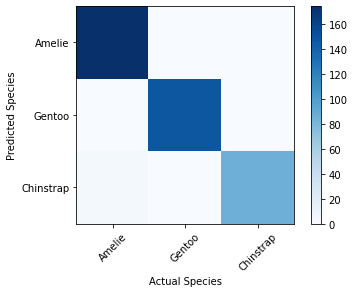

In [16]:
"""So, is the model any good? The raw accuracy reported from the validation data would seem to indicate that it predicts pretty well; but it's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performace of a classification model is to create a confusion matrix that shows a crosstab of correct and incorrect predictions for each class."""

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(penguin_classes))
plt.xticks(tick_marks, penguin_classes, rotation=45)
plt.yticks(tick_marks, penguin_classes)
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()

## 9. Use the trained model

In [17]:
"""Now that we have a model we believe is reasonably accurate, we can use it to predict the species of new penguin observations:"""

# Save the model weights
model_file = 'models/penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model

New sample: [[50.4, 15.3, 20, 50]]
Prediction: Gentoo


In [24]:
out = widgets.Output(layout={'border': '0.5px solid black'})

def predict_penguin(button):
    try:
        x_new = [[culmen_length_input.value, culmen_depth_input.value, flipper_length_input.value, body_mass_input.value]]

        model = PenguinNet()
        model.load_state_dict(torch.load(model_file))

        # Set model to evaluation mode
        model.eval()

        # Get a prediction for the new data sample
        x = torch.Tensor(x_new).float()
        _, predicted = torch.max(model(x).data, 1)
        global out
        out.clear_output()
        with out:
            print('Prediction:',penguin_classes[predicted.item()])
        test_button.description='Successful!'
        test_button.icon="check"
        test_button.button_style='success'
        time.sleep(3)
        # Reset the Button 
        test_button.description='Predicted Rentals'
        test_button.icon="refresh"
        test_button.button_style='primary'
    except:
        test_button.description='Failed!'
        test_button.icon="exclamation"
        test_button.button_style='danger'
        time.sleep(3)
        # Reset the Button 
        test_button.description='Predicted Iris'
        test_button.icon="refresh"
        test_button.button_style='primary'


style = {'description_width': 'initial'}

culmen_length_input = widgets.BoundedFloatText(
    value=2.0,
    min=35.0,
    max=55.0,
    step=0.5,
    description='Culmen Length:',
    disabled=False,
    style=style
)

culmen_depth_input = widgets.BoundedFloatText(
    value=2.0,
    min=10.0,
    max=20.0,
    step=0.5,
    description='Culmen Depth:',
    disabled=False,
    style=style
)

flipper_length_input = widgets.BoundedFloatText(
    value=1.0,
    min=15.0,
    max=25.0,
    step=0.5,
    description='Flipper Length:',
    disabled=False,
    style=style
)

body_mass_input = widgets.BoundedFloatText(
    value=1.0,
    min=35.0,
    max=60.0,
    step=0.5,
    description='Body Mass:',
    disabled=False,
    style=style
)

test_button=widgets.Button(
    description='Predicted Penguin Species',
    disabled=False,
    button_style='primary', 
    tooltip="Click to predict the Penguin species",
    icon='refresh')

form=widgets.VBox([culmen_length_input, culmen_depth_input, flipper_length_input, body_mass_input])   

button_form = widgets.VBox([test_button, out])

display_form = widgets.HBox([form, button_form])

display(display_form)

test_button.on_click(predict_penguin)